<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [187]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


### Load Data From CSV File


In [188]:
df = pd.read_csv(r'C:\Users\user\Downloads\loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [45]:
df.shape

(346, 10)

### Convert to date time object


In [189]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [47]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [8]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\user\anaconda3a

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.10.14 |                0         159 KB  anaconda
    certifi-2020.6.20          |           py37_0         160 KB  anaconda
    openssl-1.1.1h             |       he774522_0         5.8 MB  anaconda
    seaborn-0.11.0             |             py_0         216 KB  anaconda
    ------------------------------------------------------------
                                           Total:         6.3 MB

The following packages will be UPDATED:

  seaborn                    pkgs/main::seaborn-0.10.0-py_0 --> anaconda::seaborn-0.11.0-py_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2021.5.3~ --> 

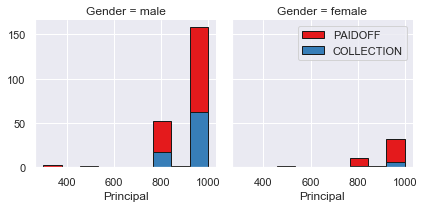

In [190]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

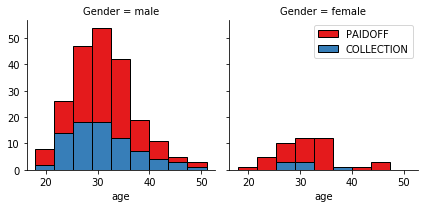

In [49]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

In [191]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['dayofweek']
df_1 = pd.DataFrame(df['dayofweek'])
df_1.head()

,dayofweek
0,3
1,3
2,3
3,4
4,4


# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


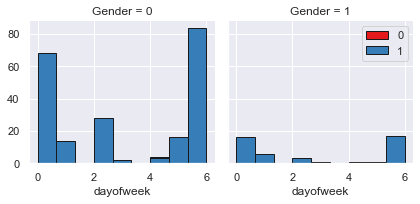

In [405]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [192]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head(60)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [182]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
0       PAIDOFF        0.731293
        COLLECTION     0.268707
1       PAIDOFF        0.865385
        COLLECTION     0.134615
Name: loan_status, dtype: float64

In [341]:
from sklearn.preprocessing import LabelEncoder

le_Gender = LabelEncoder()
le_education = LabelEncoder()
le_loan_status = LabelEncoder()
df['Gender'] = le_Gender.fit_transform(df['Gender'])
df['education']= le_education.fit_transform(df['education'])
df['loan_status'] = le_loan_status.fit_transform(df['loan_status'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,1,1000,30,2016-09-08,2016-10-07,45,1,0,3,0
1,2,2,1,1000,30,2016-09-08,2016-10-07,33,0,1,3,0
2,3,3,1,1000,15,2016-09-08,2016-09-22,27,3,0,3,0
3,4,4,1,1000,30,2016-09-09,2016-10-08,28,3,1,4,1
4,6,6,1,1000,30,2016-09-09,2016-10-08,29,3,0,4,1


In [342]:
df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status                int32
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                  int64
Gender                     int64
dayofweek                  int64
weekend                    int64
dtype: object

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


## One Hot Encoding

#### How about education?


In [54]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [343]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,1
1,1000,30,33,1,0
2,1000,15,27,0,3
3,1000,30,28,1,3
4,1000,30,29,0,3


In [229]:
df['education'].head()

0    1
1    0
2    3
3    3
4    3
Name: education, dtype: int32

In [375]:
     # variable to hold the count
cnt = 0
  
# list to hold visited values
visited = []
  
# loop for counting the unique
# values in height
for i in range(0, len(df['education'])):
    
    if df['education'][i] not in visited: 
        
          visited.append(df['education'][i])
          
          cnt += 1
  
print("No.of.unique values :",
      cnt)
  
print("unique values :",
     sorted(visited))

No.of.unique values : 4
unique values : [0, 1, 2, 3]


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [344]:
Feature = df[['Principal','terms','age','Gender','weekend','education']]
#Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
#Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,education
0,1000,30,45,0,0,1
1,1000,30,33,1,0,0
2,1000,15,27,0,0,3
3,1000,30,28,1,1,3
4,1000,30,29,0,1,3


In [280]:
Feature.isnull().sum()

Principal    0
terms        0
age          0
Gender       0
weekend      0
education    0
dtype: int64

### Feature Selection


Let's define feature sets, X:


In [400]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,education
0,1000,30,45,0,0,1
1,1000,30,33,1,0,0
2,1000,15,27,0,0,3
3,1000,30,28,1,1,3
4,1000,30,29,0,1,3


What are our lables?


In [346]:
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1])

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [393]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.64691859],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
        -1.5212695 ],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
         1.10178323],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
         1.10178323],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
         1.10178323]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [348]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 6) (276,)
Test set: (70, 6) (70,)


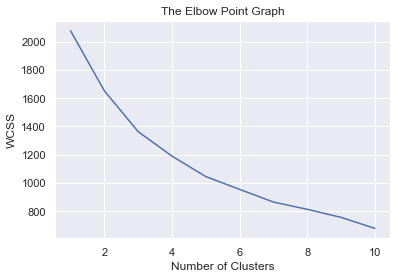

the best number of k is 7


In [288]:
# the best k - Elbow method 
from sklearn.cluster import KMeans
wcss = []
range_values = range(1,11)
for i in range_values:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
sns.set()
plt.plot(range(1,11), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

print ('the best number of k is 7')

In [349]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 10
mean_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    #Predict 
    yhat=neigh.predict(X_test)
    #accuracy classification score
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    
print( "The best accuracy was with %.2f"% mean_acc.max(), "with k=", mean_acc.argmax()+1)
print('The best k number is 7')

The best accuracy was with 0.77 with k= 7
The best k number is 7


In [350]:
from sklearn import metrics
print("Train set Accuracy: %.2f "% metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: %.2f"% metrics.accuracy_score(y_test, yhat))

Train set Accuracy: 0.79 
Test set Accuracy: 0.77


In [351]:
from sklearn.metrics import f1_score
f =f1_score(y_test, yhat, average='weighted') 
print('f1 score: %.2f'% f)

f1 score: 0.77


In [352]:
from sklearn.metrics import jaccard_score
j= jaccard_score(y_test, yhat,pos_label=1)
print('Jaccard score: %.2f'% j)

Jaccard score: 0.75


In [394]:
kmeans = KMeans(n_clusters=7, init='k-means++', random_state=0)
kmeans.fit(X)
#label
label = kmeans.labels_
label

array([5, 4, 5, 4, 3, 3, 3, 6, 2, 1, 3, 4, 6, 6, 0, 6, 0, 3, 3, 0, 6, 0,
       1, 1, 3, 3, 1, 3, 3, 3, 6, 0, 0, 4, 6, 1, 6, 4, 1, 0, 3, 1, 4, 4,
       0, 0, 6, 0, 0, 1, 1, 0, 0, 3, 6, 0, 0, 0, 6, 1, 4, 6, 6, 0, 3, 4,
       0, 6, 6, 6, 4, 4, 1, 4, 1, 6, 0, 3, 3, 0, 4, 1, 3, 1, 6, 0, 0, 3,
       6, 6, 4, 3, 3, 3, 6, 3, 0, 0, 6, 3, 0, 6, 6, 3, 3, 6, 1, 1, 0, 6,
       1, 0, 4, 6, 0, 4, 6, 1, 0, 0, 6, 4, 0, 6, 4, 5, 1, 2, 2, 5, 5, 4,
       2, 4, 5, 5, 2, 5, 4, 5, 5, 5, 5, 5, 5, 2, 5, 1, 2, 5, 5, 5, 4, 2,
       5, 2, 5, 4, 5, 2, 2, 5, 5, 4, 4, 2, 5, 5, 5, 5, 4, 2, 5, 4, 5, 5,
       2, 5, 5, 5, 4, 5, 5, 4, 1, 4, 5, 5, 5, 5, 5, 5, 5, 5, 1, 2, 2, 5,
       4, 5, 5, 2, 5, 2, 5, 5, 4, 1, 4, 6, 4, 2, 2, 5, 4, 2, 2, 5, 5, 2,
       4, 6, 5, 1, 5, 4, 5, 4, 4, 5, 5, 4, 5, 4, 5, 5, 5, 2, 2, 5, 2, 2,
       1, 5, 5, 5, 5, 5, 5, 5, 2, 4, 5, 5, 5, 5, 2, 5, 5, 5, 6, 0, 6, 1,
       6, 0, 3, 0, 3, 0, 6, 0, 0, 3, 0, 3, 6, 6, 0, 1, 3, 0, 6, 0, 4, 4,
       0, 3, 0, 4, 1, 4, 3, 1, 0, 1, 0, 0, 1, 0, 6,

In [395]:
kmeans.cluster_centers_.shape

(7, 6)

In [396]:

cluster_centers= pd.DataFrame(data=kmeans.cluster_centers_ , columns=[Feature.columns])
cluster_centers

,Principal,terms,age,Gender,weekend,education
0,0.486262,0.860078,-0.209244,-0.420560,0.829340,-0.830250
1,-0.798330,-1.010525,1.272837,-0.277055,0.464062,-0.736596
2,-1.955220,-1.030127,-0.122591,-0.327282,-1.137941,0.314867
3,0.471141,0.920718,-0.046557,-0.420560,0.829340,1.101783
4,0.123562,-0.023033,-0.094842,2.377782,-0.208986,-0.075914
5,0.515785,0.390510,-0.066468,-0.420560,-1.205778,-0.086437
6,-0.126794,-1.065768,-0.452111,-0.420560,0.742739,0.766925


In [397]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Decision Tree


In [354]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
model 

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [359]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=1)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 6) (242,)
Test set: (104, 6) (104,)


In [360]:
# Model Training
model.fit( X_train , y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [378]:
#prdict
yhat = model.predict(X_test)
yhat[0:5]
df_yhat = pd.DataFrame(yhat ,columns=['loan_status'])
df_yhat.head()

,loan_status
0,1
1,1
2,1
3,1
4,1


In [379]:
from sklearn import metrics
print("DecisionTrees's Accuracy: %.2f"% metrics.accuracy_score(y_test, yhat))

DecisionTrees's Accuracy: 0.77


In [380]:
from sklearn.metrics import f1_score
f =f1_score(y_test, yhat, average='weighted') 
print('f1 score: %.2f'% f)

f1 score: 0.67


In [381]:
from sklearn.metrics import jaccard_score
j= jaccard_score(y_test, yhat,pos_label=1)
print('Jaccard score: %.2f'% j)

Jaccard score: 0.77


In [173]:
yhat = model.predict(X_test[0:5])
yhat

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [116]:
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

y_pred

df_y_pred = pd.DataFrame(data=y_pred)
df_y_pred.head()

,0
0,COLLECTION
1,PAIDOFF
2,COLLECTION
3,PAIDOFF
4,PAIDOFF


In [97]:
model.score(X , y)

0.7543352601156069

# Support Vector Machine


In [382]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 6) (276,)
Test set: (70, 6) (70,)


In [383]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

In [384]:
yhat = clf.predict(X_test)
yhat [0:5]

array([1, 1, 1, 1, 1])

In [385]:
print('Model Accuracy score: %.3f'%clf.score(X_test, y_test))

Model Accuracy score: 0.729


# Logistic Regression


In [532]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (43, 6) (43,)
Test set: (11, 6) (11,)


In [533]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [534]:
yhat = LR.predict(X_test)
yhat

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int64)

In [527]:
yhat = LR.predict(X_test[0:5])
yhat 

array([0, 1, 1, 1, 0], dtype=int64)

In [402]:
yhat_prob =LR.predict_proba(X)
yhat_prob[0:5]

array([[1.00000000e+00, 1.51583746e-15],
       [1.00000000e+00, 7.82282995e-16],
       [1.00000000e+00, 1.27808575e-15],
       [1.00000000e+00, 4.11039392e-16],
       [1.00000000e+00, 4.08516038e-16]])

# Model Evaluation using Test set


In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation


In [413]:
test_df = pd.read_csv(r'C:\Users\user\Downloads\loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [414]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [415]:
test_df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                    object
dtype: object

In [407]:
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [420]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,1,1000,30,2016-09-08,2016-10-07,50,0,0,3,0
1,5,5,1,300,7,2016-09-09,2016-09-15,35,2,1,4,1
2,21,21,1,1000,30,2016-09-10,2016-10-09,43,1,0,5,1
3,24,24,1,1000,30,2016-09-10,2016-10-09,26,3,1,5,1
4,35,35,1,800,15,2016-09-11,2016-09-25,29,0,1,6,1


In [416]:
test_df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                    object
dtype: object

In [421]:
le_Gender = LabelEncoder()
le_education = LabelEncoder()
le_loan_status = LabelEncoder()
test_df['Gender'] = le_Gender.fit_transform(test_df['Gender'])
test_df['education']= le_education.fit_transform(test_df['education'])
test_df['loan_status'] = le_loan_status.fit_transform(test_df['loan_status'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,1,1000,30,2016-09-08,2016-10-07,50,0,0,3,0
1,5,5,1,300,7,2016-09-09,2016-09-15,35,2,1,4,1
2,21,21,1,1000,30,2016-09-10,2016-10-09,43,1,0,5,1
3,24,24,1,1000,30,2016-09-10,2016-10-09,26,3,1,5,1
4,35,35,1,800,15,2016-09-11,2016-09-25,29,0,1,6,1


In [422]:
test_df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status                int64
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                  int64
Gender                     int64
dayofweek                  int64
weekend                    int64
dtype: object

In [477]:
Featurs = test_df[['Principal', 'terms', 'age', 'education', 'weekend','Gender']]
Featurs.head()

,Principal,terms,age,education,weekend,Gender
0,1000,30,50,0,0,0
1,300,7,35,2,1,1
2,1000,30,43,1,1,0
3,1000,30,26,3,1,1
4,800,15,29,0,1,1


In [478]:
Featurs.shape

(54, 6)

In [480]:
X = Featurs 
X.shape

(54, 6)

In [481]:
# Normalization 
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865, -1.50366322, -1.30384048,
        -1.97714211],
       [-3.56269116, -1.70427745,  0.53336288,  0.22394984,  0.76696499,
         0.50578054],
       [ 0.49362588,  0.92844966,  1.88080596, -0.63985669,  0.76696499,
        -1.97714211],
       [ 0.49362588,  0.92844966, -0.98251057,  1.08775637,  0.76696499,
         0.50578054],
       [-0.66532184, -0.78854628, -0.47721942, -1.50366322,  0.76696499,
         0.50578054]])

In [482]:
X.shape

(54, 6)

In [483]:
y = test_df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [542]:
#Train / Test spilt 
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y , test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (43, 6) (43,)
Test set: (11, 6) (11,)


## KNN (K Nearest Neighbor)

In [488]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 10
mean_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    #Predict 
    yhat=neigh.predict(X_test)
    #accuracy classification score
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    
print( "The best accuracy was with %.2f"% mean_acc.max(), "with k=", mean_acc.argmax()+1)


The best accuracy was with 0.73 with k= 9


In [489]:
from sklearn.metrics import f1_score
f =f1_score(y_test, yhat, average='weighted') 
print('f1 score: %.2f'% f)

f1 score: 0.77


In [490]:
from sklearn.metrics import jaccard_score
j= jaccard_score(y_test, yhat,pos_label=1)
print('Jaccard score: %.2f'% j)

Jaccard score: 0.73


## Decision Tree 

In [493]:
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred  = clf.predict(X_test)

y_pred

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0], dtype=int64)

In [558]:
f =f1_score(y_test, y_pred, average='weighted') 
print('f1 score: %.2f'% f)
j= jaccard_score(y_test, y_pred,pos_label=1)
print('Jaccard score: %.2f'% j)

f1 score: 0.57
Jaccard score: 0.45


## Support Vector Machine

In [497]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train) 

SVC()

In [498]:
y_svm = clf.predict(X_test)
y_svm [0:5]

array([1, 1, 1, 1, 0], dtype=int64)

In [499]:
f =f1_score(y_test, y_svm, average='weighted') 
print('f1 score: %.2f'% f)
j= jaccard_score(y_test, y_svm,pos_label=1)
print('Jaccard score: %.2f'% j)

f1 score: 0.77
Jaccard score: 0.73


## Logistic Regression

In [543]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [544]:
y_rl = LR.predict(X_test)
y_rl

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int64)

In [557]:
f =f1_score(y_test, y_rl, average='weighted') 
print('f1 score: %.2f'% f)
j= jaccard_score(y_test, y_rl,pos_label=1)
print('Jaccard score: %.2f'% j)

f1 score: 0.64
Jaccard score: 0.55


In [554]:
y_rl_prob = LR.predict_proba(X_test)
y_rl_prob[0:5]
y_rl_prob.shape

(11, 2)

In [555]:
from sklearn.metrics import log_loss
logloss=log_loss(y_test, y_rl_prob)
print('LogLoss : %.2f'% log_loss)


LogLoss : 0.67


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                 0.73       |0.77   |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | 0.73       0.77        | NA      |
| LogisticRegression | ?       | ?        | ?       |


In [559]:
Dict = {'Algorithm':['KNN','DecisionTree','SVM','LogisticRegression'],
        'Jaccard':[0.73,0.45,0.73,0.55],'F1-score':[0.77,0.57,0.77,0.64],'LogLoss':['NA','NA','NA',0.67]}
df_report = pd.DataFrame.from_dict(Dict)
  
df_report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.73,0.77,NA
1,DecisionTree,0.45,0.57,NA
2,SVM,0.73,0.77,NA
3,LogisticRegression,0.55,0.64,0.67


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
